In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preprocessing

In [3]:
# Load dataset for FD001
train_data = pd.read_csv('CMAPSSData/train_FD001.txt', sep=" ", header=None)
test_data = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ", header=None)
rul_data = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep=" ", header=None)

# Drop the last two columns (they are all NaN)
train_data.drop(columns=[26, 27], inplace=True)
test_data.drop(columns=[26, 27], inplace=True)

# Add column names
columns = ['unit_number', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns

# Display the first few rows of the training data
print(train_data.head())

   unit_number  time_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1            1       -0.0007       -0.0004         100.0   
1            1            2        0.0019       -0.0003         100.0   
2            1            3       -0.0043        0.0003         100.0   
3            1            4        0.0007        0.0000         100.0   
4            1            5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    518.67    641.82   1589.70   1400.60     14.62  ...     521.66   
1    518.67    642.15   1591.82   1403.14     14.62  ...     522.28   
2    518.67    642.35   1587.99   1404.20     14.62  ...     522.42   
3    518.67    642.35   1582.79   1401.87     14.62  ...     522.86   
4    518.67    642.37   1582.85   1406.22     14.62  ...     522.19   

   sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0    2388.02    8138.62     8.4195       0.03        392       

Sensor data is normalized to ensure all features are on the same scale

In [4]:
# Calculate RUL for each engine in the training data
train_data['RUL'] = train_data.groupby('unit_number')['time_cycles'].transform("max") - train_data['time_cycles']

# Normalize sensor data (excluding unit_number, time_cycles, and operational settings)
sensor_columns = [f'sensor_{i}' for i in range(1, 22)]
scaler = MinMaxScaler()
train_data[sensor_columns] = scaler.fit_transform(train_data[sensor_columns])
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (20631, 27)
Test data shape: (13096, 26)


## Visualisation

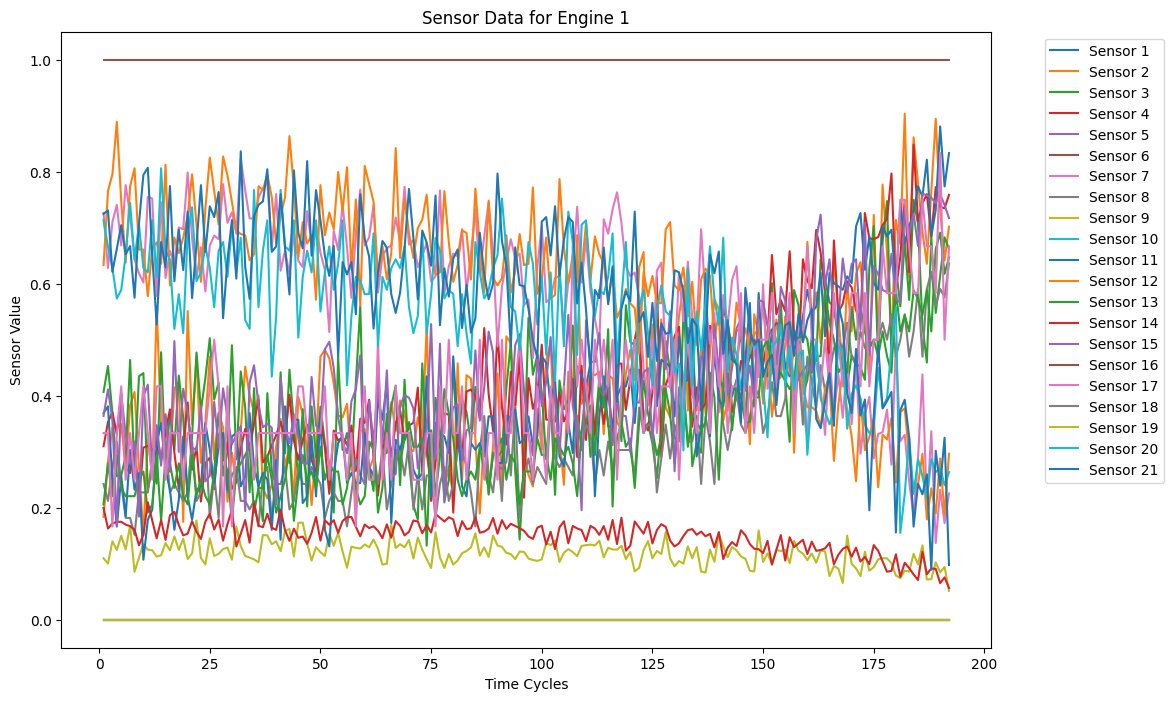

In [5]:
# Plot sensor data for the first engine
engine_1 = train_data[train_data['unit_number'] == 1]

plt.figure(figsize=(12, 8))
for i in range(1, 22):
    plt.plot(engine_1['time_cycles'], engine_1[f'sensor_{i}'], label=f'Sensor {i}')
plt.xlabel('Time Cycles')
plt.ylabel('Sensor Value')
plt.title('Sensor Data for Engine 1')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

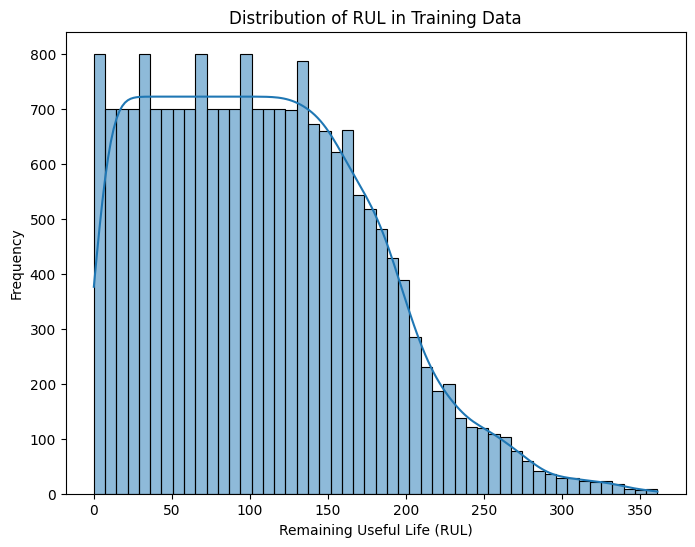

In [7]:

# Plot RUL distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_data['RUL'], bins=50, kde=True)
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of RUL in Training Data')
plt.show()

# Creating and Training the model

## Creating dataset

In [8]:
class EngineDataset(Dataset):
    def __init__(self, data, sensor_columns):
        self.features = torch.tensor(data[sensor_columns].values, dtype=torch.float32)
        self.targets = torch.tensor(data['RUL'].values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = EngineDataset(train_data, sensor_columns)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Batch size: {train_loader.batch_size}")

Number of samples in training dataset: 20631
Batch size: 64


## Autoencoder

The encoder reduces the input dimension to 8, and the decoder reconstructs the original input.

The autoencoder is used to reduce the dimensionality of the sensor data, which can help improve the performance of the LSTM model.

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

input_dim = len(sensor_columns)
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [10]:
print("Training Autoencoder...")
epochs = 20
for epoch in range(epochs):
    total_loss = 0
    for features, _ in train_loader:
        optimizer.zero_grad()
        encoded, decoded = autoencoder(features)
        loss = criterion(decoded, features)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

print("Autoencoder training complete!")

Training Autoencoder...
Epoch 1/20, Loss: 0.0386
Epoch 2/20, Loss: 0.0048
Epoch 3/20, Loss: 0.0046
Epoch 4/20, Loss: 0.0045
Epoch 5/20, Loss: 0.0041
Epoch 6/20, Loss: 0.0033
Epoch 7/20, Loss: 0.0030
Epoch 8/20, Loss: 0.0029
Epoch 9/20, Loss: 0.0029
Epoch 10/20, Loss: 0.0028
Epoch 11/20, Loss: 0.0028
Epoch 12/20, Loss: 0.0028
Epoch 13/20, Loss: 0.0028
Epoch 14/20, Loss: 0.0028
Epoch 15/20, Loss: 0.0028
Epoch 16/20, Loss: 0.0027
Epoch 17/20, Loss: 0.0027
Epoch 18/20, Loss: 0.0027
Epoch 19/20, Loss: 0.0027
Epoch 20/20, Loss: 0.0026
Autoencoder training complete!


## LSTM dataset

It uses the encoded features from the autoencoder and groups the data into sequences of length 30.

In [11]:
class LSTMRUL(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMRUL, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Use the last LSTM output
        return output

class LSTMDataset(Dataset):
    def __init__(self, data, autoencoder, sensor_columns, seq_length=30):
        self.seq_length = seq_length
        self.features = []
        self.targets = []
        data_grouped = data.groupby('unit_number')
        
        with torch.no_grad():
            for _, group in data_grouped:
                sensor_values = torch.tensor(group[sensor_columns].values, dtype=torch.float32)
                encoded_features, _ = autoencoder(sensor_values)
                rul_values = torch.tensor(group['RUL'].values, dtype=torch.float32)
                
                for i in range(len(group) - seq_length):
                    self.features.append(encoded_features[i:i+seq_length])
                    self.targets.append(rul_values[i+seq_length])
        
        self.features = torch.stack(self.features)
        self.targets = torch.stack(self.targets)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create LSTM Dataset and DataLoader
seq_length = 30
lstm_dataset = LSTMDataset(train_data, autoencoder, sensor_columns, seq_length)
lstm_loader = DataLoader(lstm_dataset, batch_size=64, shuffle=True)

print(f"Number of sequences in LSTM dataset: {len(lstm_dataset)}")
print(f"Sequence length: {seq_length}")

Number of sequences in LSTM dataset: 17631
Sequence length: 30


## Training the LSTM Model

LSTM model is defined with 8 input dimensions (from the autoencoder), 32 hidden dimensions, 2 layers, and 1 output dimension (RUL).

LSTM model is used to predict the Remaining Useful Life (RUL) based on the encoded sensor data.

In [12]:
# Train LSTM Model
print("Training LSTM Model...")
input_dim = 8  # From Autoencoder latent space
hidden_dim = 16
num_layers = 2
output_dim = 1

lstm_model = LSTMRUL(input_dim, hidden_dim, num_layers, output_dim)
lstm_criterion = nn.MSELoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

epochs = 80
for epoch in range(epochs):
    total_loss = 0
    for features, targets in lstm_loader:
        lstm_optimizer.zero_grad()
        outputs = lstm_model(features)
        loss = lstm_criterion(outputs.squeeze(), targets)
        loss.backward()
        lstm_optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(lstm_loader):.4f}")

print("LSTM training complete!")

Training LSTM Model...
Epoch 1/80, Loss: 11893.8656
Epoch 2/80, Loss: 10903.9423
Epoch 3/80, Loss: 10125.6398
Epoch 4/80, Loss: 9425.6851
Epoch 5/80, Loss: 8802.1163
Epoch 6/80, Loss: 8222.3559
Epoch 7/80, Loss: 7691.4155
Epoch 8/80, Loss: 7204.9716
Epoch 9/80, Loss: 6765.1695
Epoch 10/80, Loss: 6364.2127
Epoch 11/80, Loss: 6003.5239
Epoch 12/80, Loss: 5671.4911
Epoch 13/80, Loss: 5377.9474
Epoch 14/80, Loss: 5118.5297
Epoch 15/80, Loss: 4881.5241
Epoch 16/80, Loss: 4679.4437
Epoch 17/80, Loss: 4504.2450
Epoch 18/80, Loss: 4358.5999
Epoch 19/80, Loss: 4229.9367
Epoch 20/80, Loss: 4126.0929
Epoch 21/80, Loss: 4042.3908
Epoch 22/80, Loss: 3971.3507
Epoch 23/80, Loss: 3920.9145
Epoch 24/80, Loss: 3883.6091
Epoch 25/80, Loss: 3852.2970
Epoch 26/80, Loss: 3836.1116
Epoch 27/80, Loss: 3819.4785
Epoch 28/80, Loss: 3815.0089
Epoch 29/80, Loss: 3810.2775
Epoch 30/80, Loss: 3805.8635
Epoch 31/80, Loss: 3807.0028
Epoch 32/80, Loss: 3354.5477
Epoch 33/80, Loss: 2210.1119
Epoch 34/80, Loss: 1980.04

# Model Evaluation

In [16]:
rul_dict = {unit: rul_data.iloc[i, 0] for i, unit in enumerate(test_data['unit_number'].unique())}
test_data['RUL'] = test_data['unit_number'].map(rul_dict)
test_data[sensor_columns] = scaler.transform(test_data[sensor_columns])

class TestLSTMDataset(Dataset):
    def __init__(self, data, autoencoder, sensor_columns, seq_length=30):
        self.seq_length = seq_length
        self.features = []
        self.targets = []
        data_grouped = data.groupby('unit_number')

        with torch.no_grad():
            for _, group in data_grouped:
                sensor_values = torch.tensor(group[sensor_columns].values, dtype=torch.float32)
                encoded_features, _ = autoencoder(sensor_values)
                rul_values = torch.tensor(group['RUL'].values, dtype=torch.float32)

                for i in range(len(group) - seq_length):
                    self.features.append(encoded_features[i:i+seq_length])
                    self.targets.append(rul_values[i+seq_length])

        self.features = torch.stack(self.features)
        self.targets = torch.stack(self.targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

test_lstm_dataset = TestLSTMDataset(test_data, autoencoder, sensor_columns, seq_length)
test_loader = DataLoader(test_lstm_dataset, batch_size=64, shuffle=False)

# Evaluate LSTM on Test Data
lstm_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for features, targets in test_loader:
        outputs = lstm_model(features).squeeze()
        y_true.extend(targets.numpy())
        y_pred.extend(outputs.numpy())

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")

Test Set MAE: 36.7623
Test Set RMSE: 40.9683
